In [46]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal

from numpy import sqrt,matrix,transpose,array,fft,pi,zeros,meshgrid,random,linspace,arange,where,exp,conj,real,trace

from scipy.linalg import sqrtm,inv

In [47]:
def make_hann_2D(n):
    w = scipy.signal.hann(n)
    wx,wy = np.meshgrid(w,w)
    w2 = wx*wy
    return w2, sqrt(np.mean(w2**2))

def img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=False,usehann=True):

    n = img.shape[0]
    lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
    lx,ly = meshgrid(lvals,lvals)
    lmag  = sqrt(lx**2+ly**2)
    print(np.max(lmag))

    wind,windrms = np.ones((n,n)),1
    if usehann: 
        wind,windrms = make_hann_2D(n)
    img_ft = fft.fft2((img-img.mean())*wind)/windrms
    
    if uselogbins: 
        lbinedges = 10.**linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    
    pspec_binned = np.zeros(nbins)

    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (lmag>lbinedges[bini])&(lmag<lbinedges[bini+1])
        bin_counts[bini] = np.sum(inbin)

        pspec_binned[bini] = np.mean(np.abs(img_ft[inbin])**2)

    pspec_norm = (dtheta_rad**2)/(n**2)
    return lbincenters,pspec_binned*pspec_norm,bin_counts

def img2optimalPS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=True):
    n = img.shape[0]
    lvals = fft.fftfreq(n)*2*pi/dtheta_rad
    lxgrid,lygrid = meshgrid(lvals,lvals)
    lmaggrid = sqrt(lxgrid**2+lygrid**2)
    
    thvals = (arange(n)-n/2)*dtheta_rad # theta values
    thxgrid,thygrid = meshgrid(thvals,thvals)
    
    wind,windrms = np.ones((n,n)),1.
    if usehann: 
        wind,windrms = make_hann_2D(n)
    
    Cinv = matrix(np.diag(img.flatten()!=0)) # this line must be before subtracting the mean
    img = (img-img.mean())*wind/windrms
    xir = transpose(matrix(img.flatten()))
    
    if uselogbins: 
        lbinedges = 10.**np.linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = np.linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])    
    
    def gen_Ccommabini(bini):
        inbin = (lmaggrid>=lbinedges[bini])*(lmaggrid<lbinedges[bini+1])
        ivals_inbin,jvals_inbin = where(inbin)

        lxvals,thxvals = meshgrid(lxgrid[ivals_inbin,jvals_inbin],thxgrid.flatten()) # ell_x and theta_x
        lyvals,thyvals = meshgrid(lygrid[ivals_inbin,jvals_inbin],thygrid.flatten()) # ell_y and theta_y
        Ccommabini_lu = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))
        Ccommabini = Ccommabini_lu*conj(transpose(Ccommabini_lu))

        return Ccommabini
    
    q_allbins = np.matrix(np.zeros((nbins,1)))
    Ccomma_allbins = []
    for bini in range(nbins):
        print('generating Ccomma for bin %d'%bini)
        Ccommabini = gen_Ccommabini(bini)
        Ccomma_allbins.append(Ccommabini)
        
        print('calculating q for bin %d'%bini)
        # because xir is already zero where we have no measurements, we don't need to add the C^(-1)'s to this eqn
        q_allbins[bini] = .5*real(transpose(xir)*Ccommabini*xir).item()
    
    print('making the fisher matrix')
    F_with_Cinv = np.matrix(np.zeros((nbins,nbins)),dtype=complex)
    F = np.matrix(np.zeros((nbins,nbins)),dtype=complex)
    for i in range(nbins):
        for j in range(i,nbins):
            F_with_Cinv[i,j] = .5*trace(Cinv*Ccomma_allbins[i]*Cinv*Ccomma_allbins[j])
            F_with_Cinv[j,i] = F_with_Cinv[i,j]
            
            F[i,j] = .5*trace(Ccomma_allbins[i]*Ccomma_allbins[j])
            F[j,i] = F[i,j]
        
    return lbincenters,q_allbins*(dtheta_rad**2)/(n**2)*n**4,F,F_with_Cinv,Cinv

In [48]:
# generate an image from a non-flat power spectrum
n = 50
dtheta_amin = 3.
dtheta_rad = dtheta_amin/60*pi/180

lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
lxgrid,lygrid = meshgrid(lvals,lvals)
lmaggrid = sqrt(lxgrid**2+lygrid**2)

img_ft = (random.randn(n,n)+1j*np.random.randn(n,n))/np.sqrt(2)*(lmaggrid+1)**2
img = np.real(fft.ifft2(img_ft)) # taking the real part enforces conjugate symmetry in fourier space

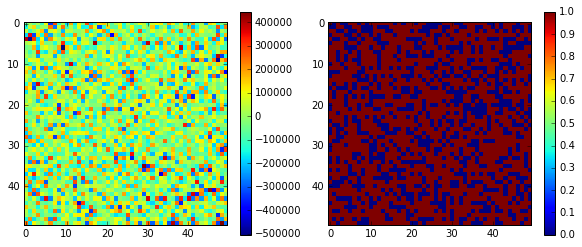

In [49]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(img,interpolation='nearest')
plt.colorbar()

plt.subplot(122)
mask = random.randn(n,n)>-.4
plt.imshow(mask,interpolation='nearest')
plt.colorbar()

In [50]:
lmin,lmax = 150,5000
nbins = 6

lbins,pspec,bin_counts = img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True)
lbins,pspec_m,bin_counts = img2PS(img*mask,dtheta_rad,nbins,lmin,lmax,uselogbins=True)

lbins_opt,q,F,F_with_Cinv,Cinv = img2optimalPS(img*mask,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=True)

5091.16882454
5091.16882454
generating Ccomma for bin 0
calculating q for bin 0
generating Ccomma for bin 1
calculating q for bin 1
generating Ccomma for bin 2
calculating q for bin 2
generating Ccomma for bin 3
calculating q for bin 3
generating Ccomma for bin 4
calculating q for bin 4
generating Ccomma for bin 5
calculating q for bin 5
making the fisher matrix


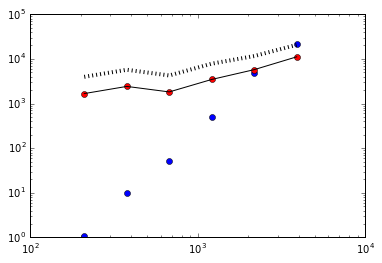

In [51]:
plt.loglog(lbins,pspec,'bo')
plt.loglog(lbins,pspec_m,'ro') 

# plt.loglog(lbins_opt,np.real(inv(F)*q),'k-')
# plt.loglog(lbins_opt,np.real(inv(F_with_Cinv)*q),'k:',linewidth=4)

plt.loglog(lbins_opt,np.array(q).T[0]/np.real(np.diag(F)),'k-')
plt.loglog(lbins_opt,np.array(q).T[0]/np.real(np.diag(F_with_Cinv)),'k:',linewidth=4)

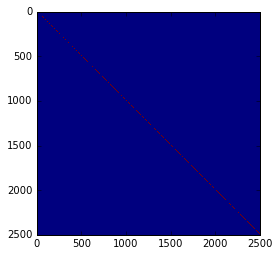

In [52]:
plt.imshow(Cinv,interpolation='nearest')

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


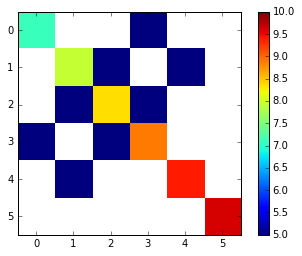

In [53]:
plt.imshow(np.log10(np.real(F)),interpolation='nearest',vmin=5,vmax=10)
plt.colorbar()

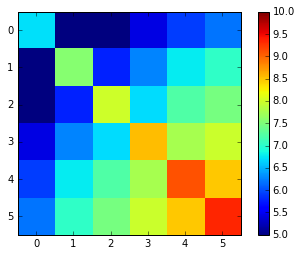

In [54]:
plt.imshow(np.log10(np.real(F_with_Cinv)),interpolation='nearest',vmin=5,vmax=10)
plt.colorbar()